## Recommender Refactoring

This notebook will go through the code I have so far in the `recommender.ipynb` file and refactor it for statistical accuracy. After reading through my code, I realized I made several errors which may have contributed to data leakage, causing the low test errors that I have been struggling with.

This notebook will also contain refactored work from `eda.py`, and `cleaning.py`.

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import nbformat
from sklearn.preprocessing import OrdinalEncoder

## EDA

First, I will redo the EDA process.

In [5]:
carmax_data_raw = pd.read_csv("../data/carmax.csv")

In [6]:
df_raw = carmax_data_raw.copy()

In [23]:
print(f'''

The data is {df_raw.shape[0]} rows by {df_raw.shape[1]} columns.
      
The data has the following column names:
{np.array([column for column in df_raw.columns]).T}
      
The following columns have a data type of "object" or "string":
{np.array([column for column in df_raw.columns 
if df_raw[column].dtype == "object" 
or df_raw[column].dtype == "string"]).T}
    
The following columns have a numeric data type
{np.array([column for column in df_raw.columns
if df_raw[column].dtype != "object"
or df_raw[column].dtype != "string"]).T}      
      ''')



The data is 132717 rows by 31 columns.
      
The data has the following column names:
['price' 'appraisal_offer' 'make_appraisal' 'model_appraisal'
 'trim_level_appraisal' 'model_year_appraisal' 'mileage_appraisal'
 'engine_appraisal' 'cylinders_appraisal' 'mpg_city_appraisal'
 'mpg_highway_appraisal' 'horsepower_appraisal' 'fuel_capacity_appraisal'
 'vehicle_type_appraisal' 'color_appraisal' 'make' 'model' 'trim_level'
 'model_year' 'mileage' 'engine' 'cylinders' 'mpg_city' 'mpg_highway'
 'horsepower' 'fuel_capacity' 'vehicle_type' 'color'
 'online_appraisal_flag' 'state' 'days_since_offer']
      
The following columns have a data type of "object" or "string":
['make_appraisal' 'model_appraisal' 'trim_level_appraisal'
 'engine_appraisal' 'vehicle_type_appraisal' 'color_appraisal' 'make'
 'model' 'trim_level' 'engine' 'vehicle_type' 'color' 'state']
    
The following columns have a numeric data type
['price' 'appraisal_offer' 'make_appraisal' 'model_appraisal'
 'trim_level_apprais

In [32]:
na_cols = [col for col in df_raw.columns if df_raw.isna().sum()[col] > 0]
df_raw[na_cols].isna().sum()

trim_level_appraisal        9683
mpg_city_appraisal            61
fuel_capacity_appraisal      111
trim_level                 10665
mpg_city                     872
mpg_highway                  893
online_appraisal_flag       1329
dtype: int64

In [36]:
df_raw.head(10)

,price,appraisal_offer,make_appraisal,model_appraisal,trim_level_appraisal,model_year_appraisal,mileage_appraisal,engine_appraisal,cylinders_appraisal,mpg_city_appraisal,mpg_highway_appraisal,horsepower_appraisal,fuel_capacity_appraisal,vehicle_type_appraisal,color_appraisal,make,model,trim_level,model_year,mileage,engine,cylinders,mpg_city,mpg_highway,horsepower,fuel_capacity,vehicle_type,color,online_appraisal_flag,state,days_since_offer
0,19500,18800,Kia,Sportage,Not Premium,2014,19300,2.4L,4,21.0,25,181,16.0,Small SUV,White,Mini,Cooper Countryman,NaN,2014,28800,1.5L,3,24.0,34.0,134,16,Small SUV,Gray,0.0,CA,0
1,24000,9000,Ford,Escape,Premium,2012,39300,1.6L,4,22.0,29,178,15.0,Small SUV,White,Jeep,Cherokee,Premium,2017,20000,3.2L,6,19.0,27.0,271,15,Small SUV,Black,0.0,IL,0
2,24000,9800,Dodge,Challenger,Not Premium,2013,106100,3.6L,6,19.0,30,305,18.0,Sports Car,Gray,BMW,530e Plug-in Hybrid,Not Premium,2014,11300,2.0L,4,NaN,NaN,248,12,Luxury,White,0.0,CA,0
3,33000,14600,Toyota,Tacoma,Premium,2014,105800,3.5L,6,19.0,24,278,21.0,Pickup,Gray,Land Rover,Range Rover Velar,Not Premium,2014,40000,3.0L,6,18.0,24.0,380,16,Medium SUV,Black,1.0,CA,1
4,14200,19500,Jeep,Cherokee,Not Premium,2015,20400,2.4L,4,22.0,31,180,15.0,Medium SUV,Burgundy,Ford,C-Max,Premium,2013,40700,2.0L,4,NaN,NaN,188,14,Small SUV,Gold,0.0,FL,0
5,17200,900,Chevrolet,Aveo,Not Premium,2005,114300,1.6L,4,27.0,37,103,11.0,Compact,Blue,Mini,Cooper Countryman,NaN,2015,13500,1.5L,3,24.0,33.0,134,16,Small SUV,Black,0.0,CA,0
6,25500,3400,Chevrolet,Cruze,Not Premium,2008,97300,1.4L,4,28.0,42,138,12.0,Compact,White,Jeep,Cherokee,Premium,2017,10000,2.0L,4,21.0,29.0,270,15,Small SUV,Gray,0.0,IN,0
7,18700,1100,Chevrolet,Impala,Premium,2006,145600,3.9L,6,17.0,27,230,17.0,Full Size,White,Chevrolet,Impala,Not Premium,2014,22200,3.6L,6,19.0,28.0,305,18,Full Size,Black,0.0,GA,0
8,19500,15000,GMC,Yukon,Not Premium,2009,51600,5.3L,8,15.0,21,320,26.0,Large SUV,Black,Jaguar,XE,Not Premium,2013,10500,2.0L,4,21.0,30.0,240,16,Luxury,Red,0.0,CA,0
9,26200,7500,Mazda,Mazda6,Not Premium,2010,93900,2.5L,4,26.0,38,184,16.0,Mid Size,Black,BMW,530e Plug-in Hybrid,Not Premium,2014,44200,2.0L,4,NaN,NaN,248,12,Luxury,White,0.0,NV,0


In [37]:
df_raw.describe()

,price,appraisal_offer,model_year_appraisal,mileage_appraisal,cylinders_appraisal,mpg_city_appraisal,mpg_highway_appraisal,horsepower_appraisal,fuel_capacity_appraisal,model_year,mileage,cylinders,mpg_city,mpg_highway,horsepower,fuel_capacity,online_appraisal_flag,days_since_offer
count,132717.000000,132717.000000,132717.000000,132717.000000,132717.000000,132656.000000,132717.000000,132717.000000,132606.000000,132717.000000,132717.000000,132717.000000,131845.000000,131824.000000,132717.000000,132717.000000,131388.000000,132717.000000
mean,21901.191257,8770.392640,2010.053347,80689.823459,4.917908,22.265996,30.140133,215.475350,17.367811,2014.187738,30852.990197,4.920184,22.433024,29.525997,237.195160,17.466594,0.318385,1.279738
std,6958.423155,7149.901735,3.931040,43875.944131,1.281485,5.437278,6.153769,73.334829,4.380204,1.889305,19024.084543,1.348566,5.475579,5.742177,75.191027,4.386103,0.465852,2.303406
min,3700.000000,0.000000,1992.000000,0.000000,3.000000,10.000000,13.000000,70.000000,7.000000,2005.000000,0.000000,0.000000,11.000000,16.000000,70.000000,1.000000,0.000000,0.000000
25%,16500.000000,3000.000000,2008.000000,47000.000000,4.000000,18.000000,25.000000,161.000000,14.000000,2013.000000,17000.000000,4.000000,19.000000,25.000000,178.000000,14.000000,0.000000,0.000000
50%,21000.000000,7100.000000,2011.000000,74900.000000,4.000000,22.000000,30.000000,185.000000,17.000000,2014.000000,27800.000000,4.000000,22.000000,29.000000,228.000000,17.000000,0.000000,0.000000
75%,26200.000000,12800.000000,2013.000000,106600.000000,6.000000,26.000000,35.000000,278.000000,19.000000,2015.000000,40700.000000,6.000000,26.000000,33.000000,290.000000,19.000000,1.000000,1.000000
max,95200.000000,69800.000000,2019.000000,482500.000000,8.000000,60.000000,59.000000,702.000000,38.000000,2019.000000,333900.000000,16.000000,58.000000,59.000000,760.000000,48.000000,1.000000,7.000000


In [46]:
encode_cols = []
for col in df_raw.columns:
    if df_raw[col].nunique() <= 10:
        print(f"{col} has {df_raw[col].nunique()} distinct values.")
        encode_cols.append(col)
f"{encode_cols} are the columns that we could reasonably encode."

trim_level_appraisal has 2 distinct values.
cylinders_appraisal has 5 distinct values.
vehicle_type_appraisal has 10 distinct values.
trim_level has 2 distinct values.
cylinders has 10 distinct values.
vehicle_type has 10 distinct values.
online_appraisal_flag has 2 distinct values.
days_since_offer has 8 distinct values.


"['trim_level_appraisal', 'cylinders_appraisal', 'vehicle_type_appraisal', 'trim_level', 'cylinders', 'vehicle_type', 'online_appraisal_flag', 'days_since_offer'] are the columns that we could reasonably encode."

<Axes: xlabel='price', ylabel='Count'>

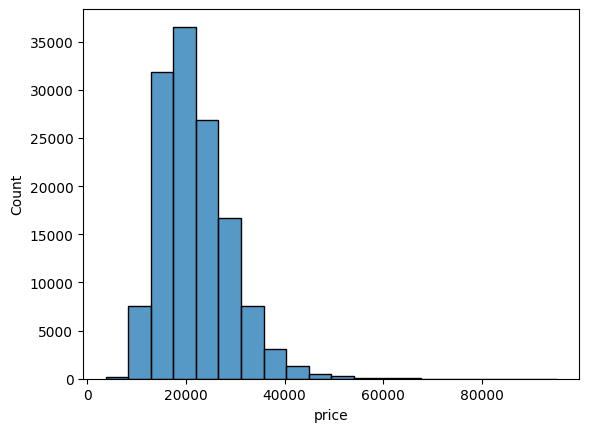

In [62]:
sns.histplot(data = df_raw,
             x = "price",
             bins = 20)

In [64]:
numeric_cols = []
for col in df_raw.columns:
    if df_raw[col].dtype != "object" or df_raw[col].dtype != "string":
        if df_raw[col].nunique() <= 10:
            print(f"{col} is categorical")
        else:
            print(f"{col} is quantitative")
            numeric_cols.append(col)
    else:
        print(f"{col} is categorical")

price is quantitative
appraisal_offer is quantitative
make_appraisal is quantitative
model_appraisal is quantitative
trim_level_appraisal is categorical
model_year_appraisal is quantitative
mileage_appraisal is quantitative
engine_appraisal is quantitative
cylinders_appraisal is categorical
mpg_city_appraisal is quantitative
mpg_highway_appraisal is quantitative
horsepower_appraisal is quantitative
fuel_capacity_appraisal is quantitative
vehicle_type_appraisal is categorical
color_appraisal is quantitative
make is quantitative
model is quantitative
trim_level is categorical
model_year is quantitative
mileage is quantitative
engine is quantitative
cylinders is categorical
mpg_city is quantitative
mpg_highway is quantitative
horsepower is quantitative
fuel_capacity is quantitative
vehicle_type is categorical
color is quantitative
online_appraisal_flag is categorical
state is quantitative
days_since_offer is categorical


In [65]:
numeric_cols

['price',
 'appraisal_offer',
 'make_appraisal',
 'model_appraisal',
 'model_year_appraisal',
 'mileage_appraisal',
 'engine_appraisal',
 'mpg_city_appraisal',
 'mpg_highway_appraisal',
 'horsepower_appraisal',
 'fuel_capacity_appraisal',
 'color_appraisal',
 'make',
 'model',
 'model_year',
 'mileage',
 'engine',
 'mpg_city',
 'mpg_highway',
 'horsepower',
 'fuel_capacity',
 'color',
 'state']

In [74]:
numeric_cols_appraisal = [col for col in numeric_cols 
                          if "_appraisal" in col]

In [75]:
numeric_cols_appraisal.append('price')
numeric_cols_appraisal

['make_appraisal',
 'model_appraisal',
 'model_year_appraisal',
 'mileage_appraisal',
 'engine_appraisal',
 'mpg_city_appraisal',
 'mpg_highway_appraisal',
 'horsepower_appraisal',
 'fuel_capacity_appraisal',
 'color_appraisal',
 'price']

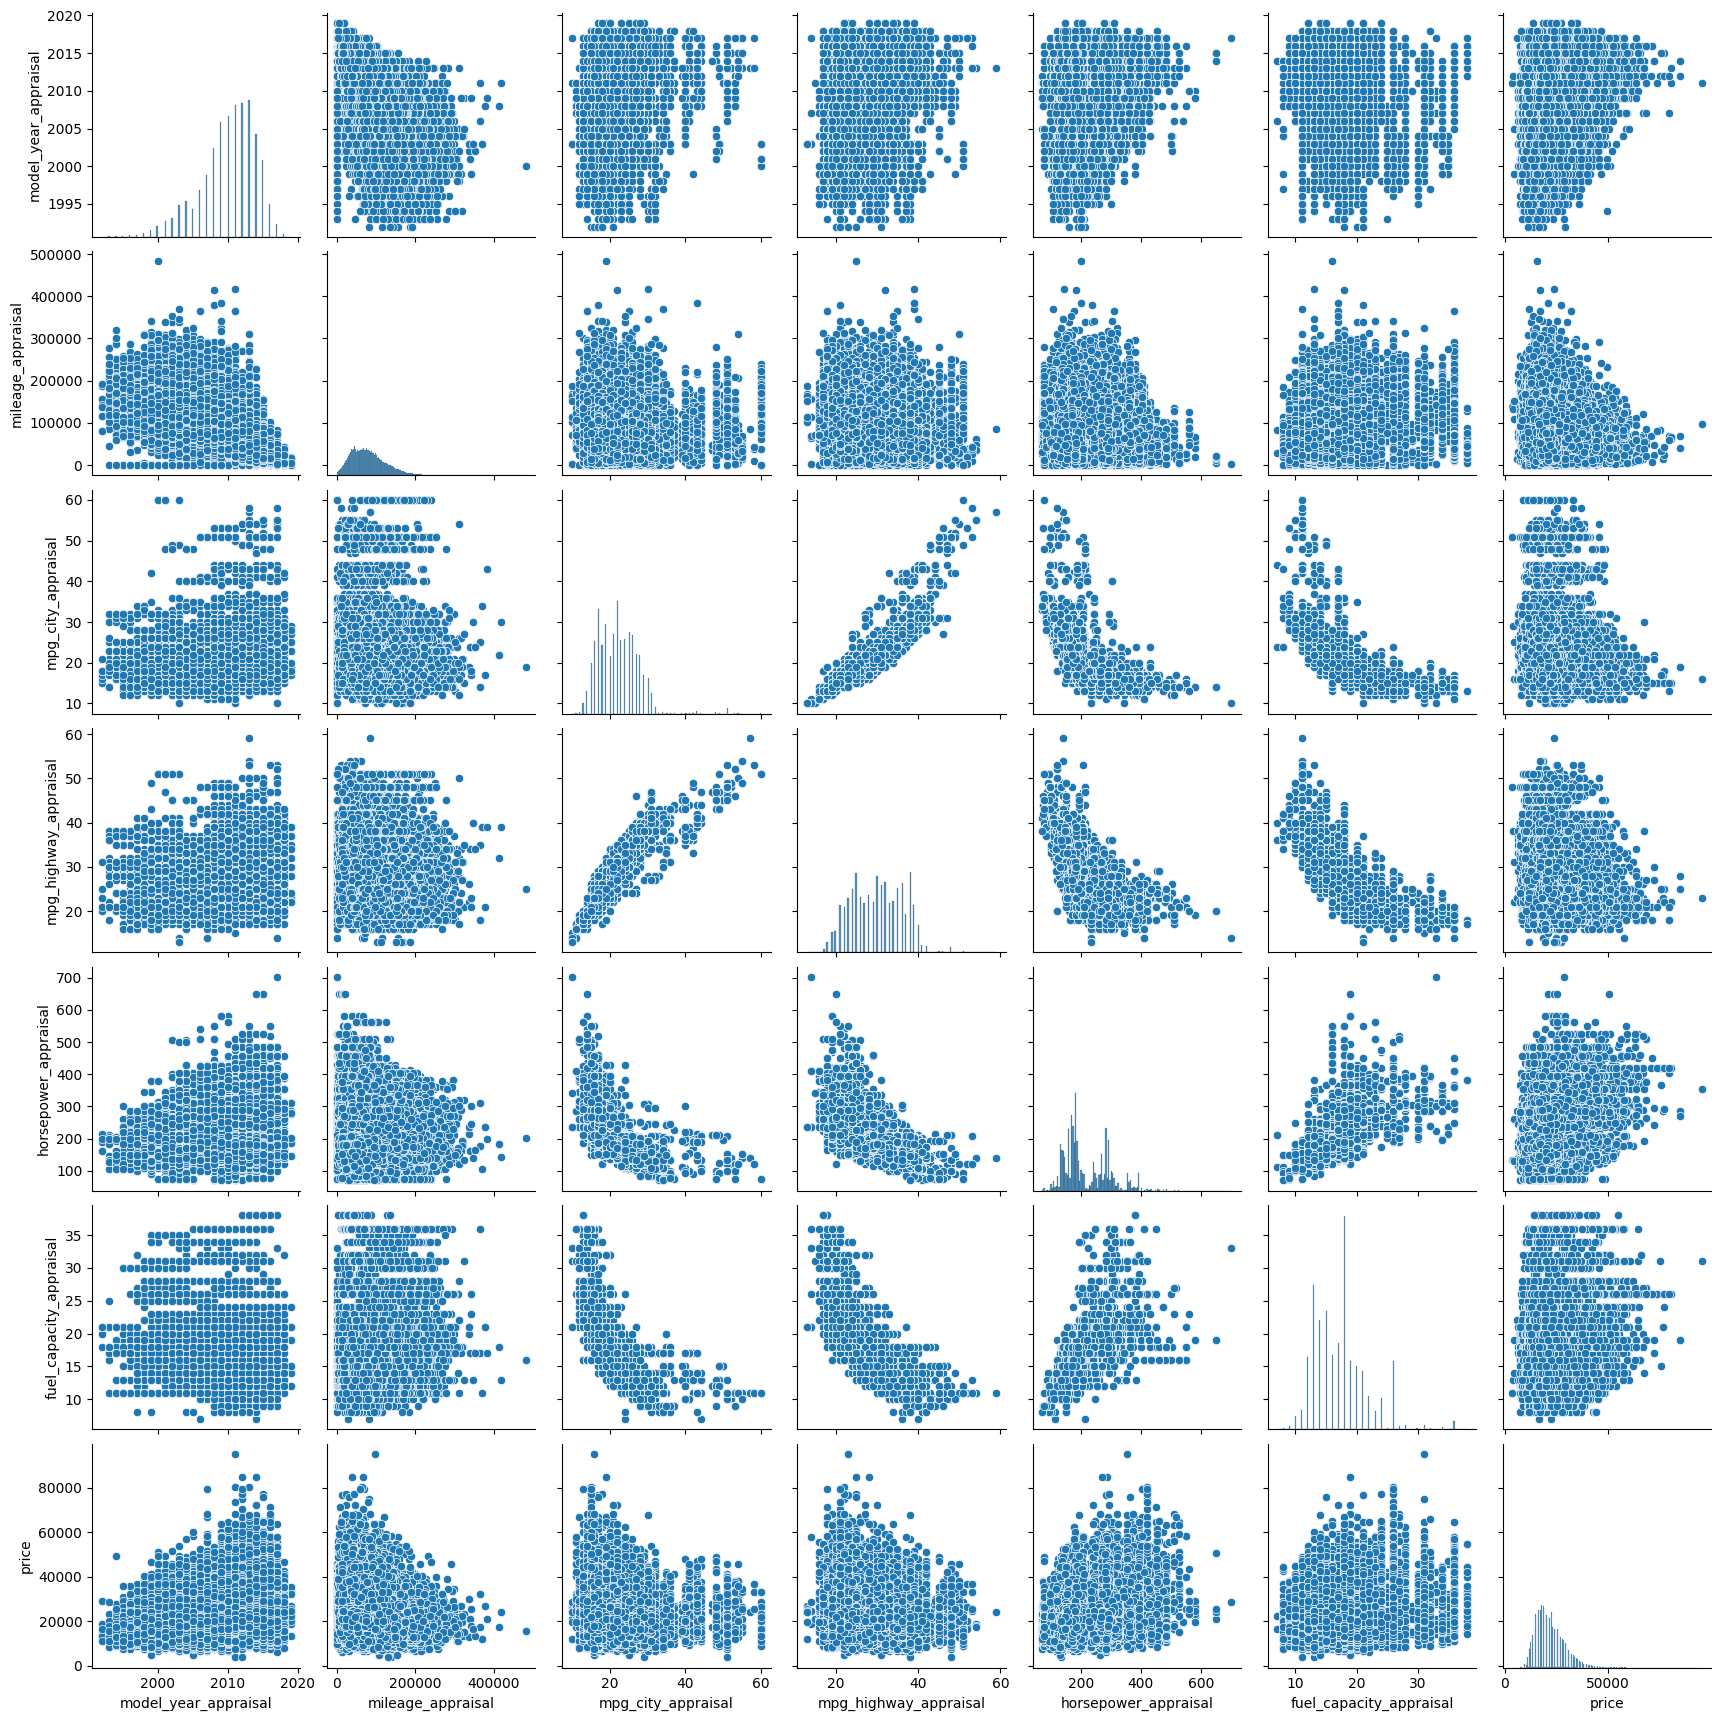

In [76]:
sns.pairplot(data = df_raw[numeric_cols_appraisal])

In [81]:
df_raw.make_appraisal.dtype != "object"

False